Минимальное значение: 0
Максимальное значение: 255
Среднее значение: 3.57
Количество ненулевых пикселей: 30958


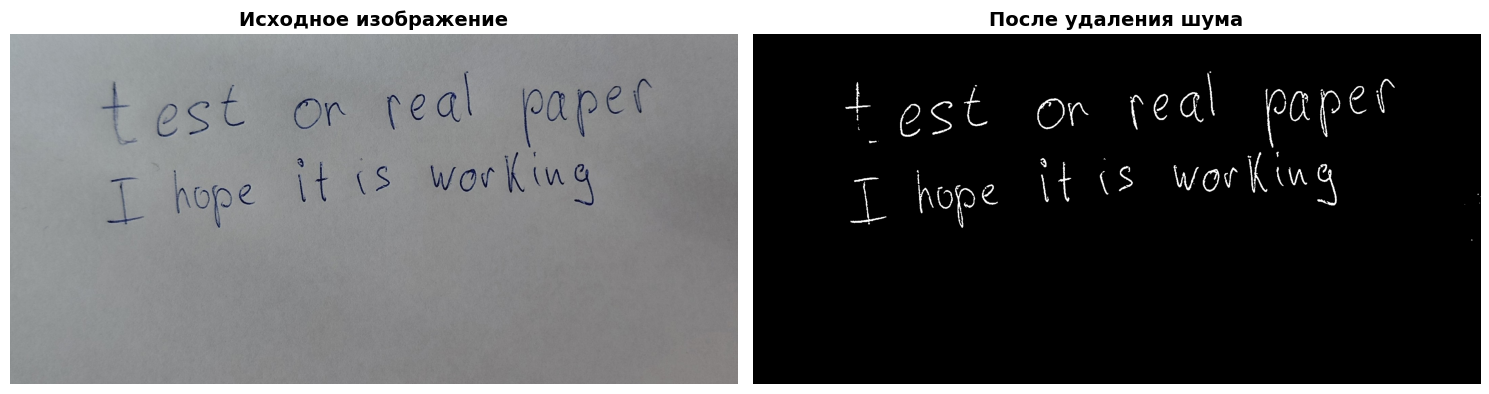

Размер исходного изображения: (1032, 2143, 3)
Размер обработанного изображения: (1032, 2143)
Тип данных: uint8
Диапазон значений: [0, 255]
Минимальное значение: 0
Максимальное значение: 255
Среднее значение: 5.94
Количество ненулевых пикселей: 95625


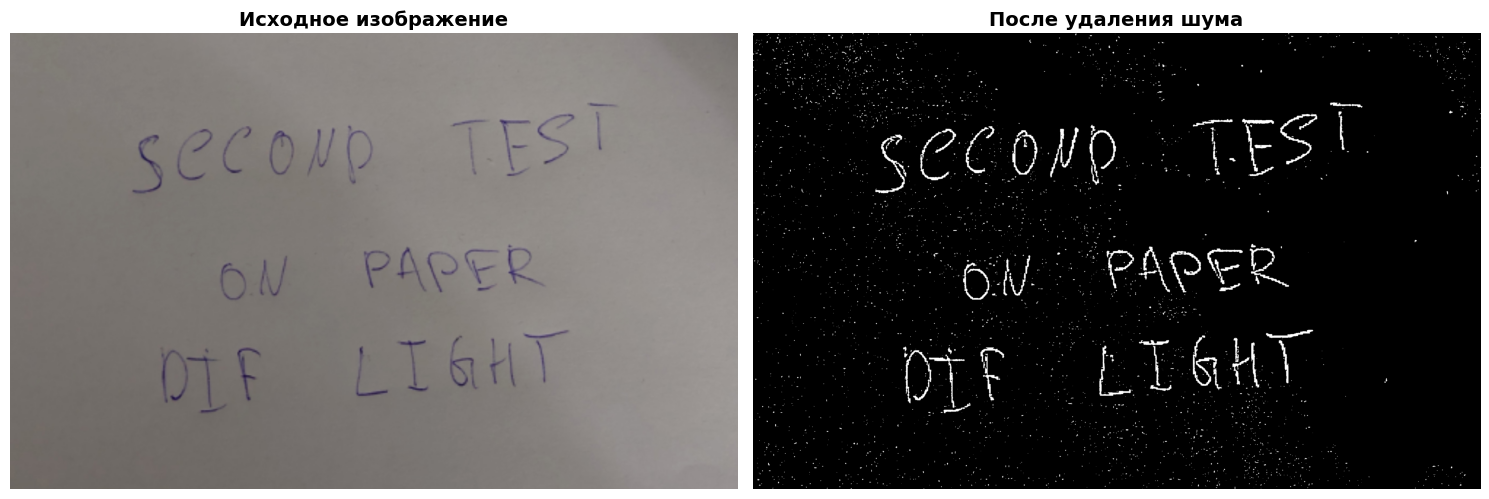

Размер исходного изображения: (1604, 2560, 3)
Размер обработанного изображения: (1604, 2560)
Тип данных: uint8
Диапазон значений: [0, 255]


In [8]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np


def advanced_noise_removal(image):
    """
    Упрощенная версия для рукописного текста — CLAHE + гамма-коррекция + морфология
    """
    # 1. Преобразуем в оттенки серого
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # 2. Улучшаем контраст с помощью CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # 3. Гамма-коррекция для усиления контраста
    # Гамма < 1 — усиливает тени (фон станет темнее), > 1 — усиливает света (текст станет ярче)
    gamma = 0.8  # попробуйте 0.7–0.9
    enhanced = np.array(255 * (enhanced / 255) ** gamma, dtype='uint8')
    
    # 4. Морфологическое удаление шума
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    denoised = cv2.morphologyEx(enhanced, cv2.MORPH_OPEN, kernel, iterations=1)
    
    return denoised
    
def prepare_handwritten_image_for_recognition(image):
    """
    Полная предобработка изображения для распознавания рукописного текста.
    Удаляет шумы и готовит изображение для модели.
    """
    # 1. Удаление шума
    denoised = advanced_noise_removal(image)
    
    # 2. Улучшение контраста
    _, otsu_thresh = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Затем адаптивная бинаризация поверх Otsu (если нужно)
    adaptive = cv2.adaptiveThreshold(
        denoised, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=15,
        C=3
    )
    binary = cv2.bitwise_and(otsu_thresh, adaptive)
    
    # 4. Удаление оставшихся шумов
    denoised_final = cv2.medianBlur(binary, 3)
    
    print(f"Минимальное значение: {denoised_final.min()}")
    print(f"Максимальное значение: {denoised_final.max()}")
    print(f"Среднее значение: {denoised_final.mean():.2f}")
    print(f"Количество ненулевых пикселей: {np.count_nonzero(denoised_final)}")
    
    return denoised_final

def test_noise_removal_function(image_path):
    """
    Тестирует функцию удаления шума с визуализацией до и после
    """
    # Загружаем изображение
    original_img = cv2.imread(image_path)
    if original_img is None:
        print(f"Ошибка: Не удалось загрузить изображение {image_path}")
        return
    
    # Конвертируем в RGB для matplotlib
    original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB) if len(original_img.shape) == 3 else original_img
    
    # Применяем функцию удаления шума
    processed_img = prepare_handwritten_image_for_recognition(original_img)
    
    # Создаем визуализацию
    plt.figure(figsize=(15, 6))
    
    # До обработки
    plt.subplot(1, 2, 1)
    if len(original_rgb.shape) == 3:
        plt.imshow(original_rgb)
    else:
        plt.imshow(original_rgb, cmap='gray')
    plt.title('Исходное изображение', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    # После обработки
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title('После удаления шума', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Вывод информации о процессе
    print(f"Размер исходного изображения: {original_img.shape}")
    print(f"Размер обработанного изображения: {processed_img.shape}")
    print(f"Тип данных: {processed_img.dtype}")
    print(f"Диапазон значений: [{processed_img.min()}, {processed_img.max()}]")


# Пример использования:
test_file_path = os.path.join('tests', 'others', 'test6.jpg')
test_noise_removal_function(test_file_path)
test_file_path = os.path.join('tests', 'others', 'test7.jpg')
test_noise_removal_function(test_file_path)